In [1]:
# Initial imports
import panel as pn
import os
from pathlib import Path
import requests
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from yahoofinancials import YahooFinancials
import json
from newsapi.newsapi_client import NewsApiClient
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
pn.extension("plotly")
from panel.interact import interact
import hvplot.pandas
import plotly.express as px


In [2]:
# Load .env enviroment variables
load_dotenv()

# Set News API Key
newsapi = NewsApiClient(api_key=os.environ["NEWS_API"])
#api_newsdata = NewsDataApiClient(apikey="newsdata")

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [3]:
# Loading Functions
# Use newsapi client to get most relevant 20 headlines per day in the past month
def get_headlines(keyword,fdate,edate):
    all_headlines = []
    all_contents = []
    all_dates = [] 
    # string conversion of dates passed in to function
    fdate_str=str(fdate.strftime("%Y-%m-%d"))
    edate_str=str(edate.strftime("%Y-%m-%d"))

    print(f"Fetching news about '{keyword}'")
    print("*" * 30)
    #while date > end_date:
    print(f"retrieving news from: {fdate} - {edate}")
    articles = newsapi.get_everything(
        q=keyword,
        # from_param=str(date)[:10],
        # to=str(date)[:10],
        from_param=fdate_str,
        to=edate_str,
        language="en",
        sort_by="relevancy",
        page=1,
    )
    headlines = []
    contents = []
    for i in range(0, len(articles["articles"])):
        headlines.append(articles["articles"][i]["title"])
        contents.append(articles["articles"][i]["content"])
    all_headlines.append(headlines)
    all_contents.append(contents)
    all_dates.append(fdate)
    #date = date - timedelta(weeks=1)
    return all_headlines, all_dates, all_contents

# Create function that computes average compound sentiment of headlines for each day
def headline_sentiment_summarizer_avg(data,sdate):
    df=data.copy()
    sentiment = []
    sentiment_pos = []
    sentiment_neg = []
    for day in data:
        day_score = []
        day_positive = []
        day_negative = []
        for h in day:
            
            if h == None:
                continue
            else:
                day_score.append(sid.polarity_scores(h)["compound"])
                day_positive.append(sid.polarity_scores(h)["pos"])
                day_negative.append(sid.polarity_scores(h)["neg"])
        sentiment.append(sum(day_score) / len(day_score))
        sentiment_pos.append(sum(day_positive) / len(day_positive))
        sentiment_neg.append(sum(day_negative) / len(day_negative))
    d={"c0":sentiment,"p0":sentiment_pos,"n0":sentiment_neg,"Date":str(sdate.strftime("%Y-%m-%d"))}
    sentiment_df=pd.DataFrame(data=d).set_index("Date")
    return sentiment_df #, sentiment_pos, sentiment_neg

In [4]:
#call and set API from yahoo financials - crude oil price
yahoo_financials = YahooFinancials('CL=F')
crude_prices=(yahoo_financials.get_historical_price_data("2020-06-01", "2022-06-01", "weekly"))

In [5]:
#set json object and write crrude prices to json
json_object= json.dumps(crude_prices['CL=F']['prices'], indent = 4)
with open("sample.json", "w") as outfile:
    outfile.write(json_object)      

In [6]:
#read json
crude_prices = pd.read_json('sample.json')

In [7]:
#create dataframe for crude prices 
crude_prices_df = pd.DataFrame(crude_prices)
#crude_prices_df.head()

In [8]:
#drop unneeded columns 
crude_prices_df.drop(['date','high','low','open','adjclose'],axis=1, inplace = True)
#crude_prices_df.head()

In [9]:
#rename columns and set index of dataframe on date
crude_prices_df.rename(columns = {'close':'Crude Close', 'volume':'Crude Volume','formatted_date':'Date'}, inplace = True)
crude_prices_df.set_index('Date', inplace = True)
#crude_prices_df.head()

In [10]:
#call yahoo financial to get gold prices 
yahoo_financials = YahooFinancials('GC=F')
gold_prices=(yahoo_financials.get_historical_price_data("2020-06-01", "2022-06-01", "weekly"))
#print(gold_prices)

In [11]:
#set json object and write gold prices to json
json_object= json.dumps(gold_prices['GC=F']['prices'], indent = 4)
with open("sample.json", "w") as outfile:
    outfile.write(json_object)

In [12]:
#read json
gold_prices = pd.read_json('sample.json')

In [13]:
#convert gold prices to dataframe
gold_prices_df = pd.DataFrame(gold_prices)
#gold_prices_df.head()

In [14]:
#drop unneeded columns from the data frame
gold_prices_df.drop(['date','high','low','open','adjclose'],axis=1, inplace = True)
#gold_prices_df.head()

In [15]:
#rename columns and set index to date 
gold_prices_df.rename(columns = {'close':'Gold Close', 'volume':'Gold Volume','formatted_date':'Date'}, inplace = True)
gold_prices_df.set_index('Date', inplace = True)

In [16]:
#call api for SPY s and p 500 data
yahoo_financials = YahooFinancials('SPY')
SPY_prices=(yahoo_financials.get_historical_price_data("2020-06-01", "2022-06-01", "weekly"))
#print(SPY_prices)

In [17]:
#set json object and write data 
json_object= json.dumps(SPY_prices['SPY']['prices'], indent = 4)
with open("sample.json", "w") as outfile:
    outfile.write(json_object)

In [18]:
#read the json data
SPY_prices = pd.read_json('sample.json')

In [19]:
#convert json to a data frame
SPY_prices_df = pd.DataFrame(SPY_prices)
#SPY_prices_df.head()

In [20]:
#drop unneedeeed columns, rename columns and set index to date 
SPY_prices_df.drop(['date','high','low','open','adjclose'],axis=1, inplace = True)
SPY_prices_df.rename(columns = {'close':'SPY Close', 'formatted_date':'Date','volume':'SPY Volume'}, inplace = True)
SPY_prices_df.set_index('Date', inplace = True)

In [21]:
#call api and get bitcoin prices 
yahoo_financials = YahooFinancials('BTC-USD')
BTC_prices=(yahoo_financials.get_historical_price_data("2020-06-01", "2022-06-01", "weekly"))
#print(BTC_prices)

In [22]:
#set sson object and write data
json_object= json.dumps(BTC_prices['BTC-USD']['prices'], indent = 4)
with open("sample.json", "w") as outfile:
    outfile.write(json_object)

In [23]:
#read json data
BTC_prices = pd.read_json('sample.json')

In [24]:
#create Btc data frame
BTC_prices_df = pd.DataFrame(BTC_prices)
#BTC_prices_df.head()

In [25]:
#drop undeeded columns, rename columns set index of data frame to date
BTC_prices_df.drop(['date','high','low','open','adjclose'],axis=1, inplace = True)
BTC_prices_df.rename(columns = {'close':'BTC Close', 'volume':'BTC Volume','formatted_date':'Date'}, inplace = True)
BTC_prices_df.set_index('Date', inplace = True)

In [26]:
# call yahoo financial api for eth data
yahoo_financials = YahooFinancials('ETH-USD')
ETH_prices=(yahoo_financials.get_historical_price_data("2020-06-01", "2022-06-01", "weekly"))
#print(ETH_prices)

In [27]:
#set json obect write data to json
json_object= json.dumps(ETH_prices['ETH-USD']['prices'], indent = 4)
with open("sample.json", "w") as outfile:
    outfile.write(json_object)

In [28]:
#read json data
ETH_prices = pd.read_json('sample.json')

In [29]:
#create eath data frame
ETH_prices_df = pd.DataFrame(ETH_prices)
#ETH_prices_df.head()

In [30]:
#drop unneeded columns, rename columns, set index to date
ETH_prices_df.drop(['date','high','low','open','adjclose'],axis=1, inplace = True)
ETH_prices_df.rename(columns = {'close':'ETH Close', 'volume':'ETH Volume','formatted_date':'Date'}, inplace = True)
ETH_prices_df.set_index('Date', inplace = True)


In [31]:
#concatenate asset dataframes into one data frame
combined_asset_data = pd.concat([crude_prices_df, gold_prices_df, BTC_prices_df, ETH_prices_df,SPY_prices_df], axis="columns", join="inner")

# Adding Features to Predict On to determine if the Asset should move up or down in 2 periods
combined_asset_data[ 'SPY UP(2)' ] = combined_asset_data['SPY Close'].diff(periods=2).apply(lambda x: 1 if x <= 0 else 0)
combined_asset_data[ 'CRUDE UP(2)' ] = combined_asset_data['Crude Close'].diff(periods=2).apply(lambda x: 1 if x <= 0 else 0)
combined_asset_data[ 'GOLD UP(2)' ] = combined_asset_data['Gold Close'].diff(periods=2).apply(lambda x: 1 if x <= 0 else 0)
combined_asset_data[ 'BTC UP(2)' ] = combined_asset_data['BTC Close'].diff(periods=2).apply(lambda x: 1 if x <= 0 else 0)
combined_asset_data[ 'ETH UP(2)' ] = combined_asset_data['ETH Close'].diff(periods=2).apply(lambda x: 1 if x <= 0 else 0)

# Setting Index to datetime to assist with merging with sentiments 
combined_asset_data.index = pd.to_datetime(combined_asset_data.index)

In [32]:
combined_asset_data

,Crude Close,Crude Volume,Gold Close,Gold Volume,BTC Close,BTC Volume,ETH Close,ETH Volume,SPY Close,SPY Volume,SPY UP(2),CRUDE UP(2),GOLD UP(2),BTC UP(2),ETH UP(2)
Date,,,,,,,,,,,,,,,
2020-06-01,39.549999,1927914,1676.199951,6676,9758.852539,194228716225,245.167252,74719731540,319.339996,448912200,0,0,0,0,0
2020-06-08,36.259998,2118960,1729.300049,2660,9386.788086,160324519712,234.114700,61122813318,304.209991,650043700,0,0,0,0,0
2020-06-15,39.750000,1170882,1745.900024,1700,9303.629883,138300100692,228.989822,51716551698,308.640015,573187400,1,0,0,1,1
2020-06-22,38.490002,1991836,1772.500000,3830,9143.582031,125863637229,225.347168,51841369946,300.049988,493363100,1,0,0,1,1
2020-06-29,40.650002,1468238,1784.000000,2116,9073.942383,102779717630,227.664597,41125720927,312.230011,334908800,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-02,109.769997,1355247,1881.199951,1146,34059.265625,239044762282,2517.459961,127664655328,411.339996,727288500,1,0,1,1,1
2022-05-09,110.489998,1705170,1807.400024,3224,31305.113281,357800928090,2145.706787,217861782391,401.720001,659709500,1,0,1,1,1
2022-05-16,113.230003,943867,1841.800049,714,30323.722656,196429842104,2043.170166,111825123089,389.630005,509269500,1,0,1,1,1


# The code below is commented out but was used to pull the news api data for 2 years. This is using a paid plan and to minimize cost we do not run unless our saved sentiment scores get corrupted

In [33]:
# sid = SentimentIntensityAnalyzer()
# sp_sentiment_df=pd.DataFrame()
# gold_sentiment_df=pd.DataFrame()
# crude_sentiment_df=pd.DataFrame()
# btc_sentiment_df=pd.DataFrame()
# eth_sentiment_df=pd.DataFrame()
# for fdate in pd.to_datetime(pd.Series(list(combined_asset_data.index.values))):
#     edate = fdate
#     fdate = fdate - timedelta(days=6)
#     #S&P 500
#     sp_headlines, sp_dates, sp_contents = get_headlines("S&P 500",fdate,edate)
#     temp_sp_df = headline_sentiment_summarizer_avg(sp_contents,fdate)
#     sp_sentiment_df = pd.concat([sp_sentiment_df,temp_sp_df])
#     # Gold
#     gold_headlines, gold_dates, gold_contents = get_headlines("Gold",fdate,edate)
#     temp_gold_df = headline_sentiment_summarizer_avg(gold_contents,fdate)
#     gold_sentiment_df = pd.concat([gold_sentiment_df,temp_gold_df])
#     # Crude Oil
#     crude_headlines, crude_dates, crude_contents = get_headlines("Crude Oil",fdate,edate)
#     temp_crude_df = headline_sentiment_summarizer_avg(crude_contents,fdate)
#     crude_sentiment_df = pd.concat([crude_sentiment_df,temp_crude_df])
#     # Bitcoin
#     btc_headlines, btc_dates, btc_contents = get_headlines("Bitcoin",fdate,edate)
#     temp_btc_df = headline_sentiment_summarizer_avg(btc_contents,fdate)
#     btc_sentiment_df = pd.concat([btc_sentiment_df,temp_btc_df])
#     # Ethereum
#     eth_headlines, eth_dates, eth_contents = get_headlines("Ethereum",fdate,edate)
#     temp_eth_df = headline_sentiment_summarizer_avg(eth_contents,fdate)
#     eth_sentiment_df = pd.concat([eth_sentiment_df,temp_eth_df])

# #Save sentiment score dataframes to disk to use later if needed (Api calls run out)
# sp_sentiment_df.to_csv('./sp_sentiment.csv')
# gold_sentiment_df.to_csv('./gold_sentiment.csv')
# crude_sentiment_df.to_csv('./crude_sentiment.csv')
# btc_sentiment_df.to_csv('./btc_sentiment.csv')
# eth_sentiment_df.to_csv('./eth_sentiment.csv')
    
    
    
    

# The commented out code below used to save sentiment scores as csv file that were compiled from news api code above

In [34]:
# #Save sentiment score dataframes to disk to use later if needed (Api calls run out)
# sp_sentiment_df.to_csv('./sp_sentiment.csv')
# gold_sentiment_df.to_csv('./gold_sentiment.csv')
# crude_sentiment_df.to_csv('./crude_sentiment.csv')
# btc_sentiment_df.to_csv('./btc_sentiment.csv')
# eth_sentiment_df.to_csv('./eth_sentiment.csv')


# The code below loads in the saved sentiment code from the 2 commented sections above that generated and saved it

In [35]:
#Load saved sentiment scores 
sp_sentiment_df = pd.read_csv('./sp_sentiment.csv', index_col='Date', infer_datetime_format=True)
gold_sentiment_df = pd.read_csv('./gold_sentiment.csv', index_col='Date', infer_datetime_format=True)
crude_sentiment_df = pd.read_csv('./crude_sentiment.csv', index_col='Date', infer_datetime_format=True)
btc_sentiment_df = pd.read_csv('./btc_sentiment.csv', index_col='Date', infer_datetime_format=True)
eth_sentiment_df = pd.read_csv('./eth_sentiment.csv', index_col='Date', infer_datetime_format=True)

# renaming sentiment columns
sp_sentiment_df.columns=['sp500 c0','sp500 p0', 'sp500 n0']
gold_sentiment_df.columns=['gold c0','gold p0', 'gold n0']
crude_sentiment_df.columns=['crude c0','crude p0', 'crude n0']
btc_sentiment_df.columns=['btc c0','btc p0', 'btc n0']
eth_sentiment_df.columns=['eth c0','eth p0', 'eth n0']


In [36]:
# Combining sentiment dataframes for each asset into a single sentiment dataframe
all_sentiment_df = pd.concat([sp_sentiment_df,gold_sentiment_df,crude_sentiment_df,btc_sentiment_df,eth_sentiment_df], axis=1, join="inner")

In [37]:
all_sentiment_df

,sp500 c0,sp500 p0,sp500 n0,gold c0,gold p0,gold n0,crude c0,crude p0,crude n0,btc c0,btc p0,btc n0,eth c0,eth p0,eth n0
Date,,,,,,,,,,,,,,,
2020-05-26,0.173359,0.08800,0.04903,0.200108,0.08425,0.03804,-0.123743,0.07352,0.09972,0.108461,0.07102,0.04326,0.200015,0.07395,0.02607
2020-06-02,0.010131,0.06285,0.06118,0.197979,0.09417,0.04655,-0.080413,0.07724,0.08889,0.092044,0.06111,0.04534,0.222429,0.08383,0.03457
2020-06-09,-0.024901,0.04645,0.05272,0.159158,0.07124,0.03753,-0.140668,0.05400,0.07757,0.119311,0.06868,0.03945,0.121122,0.06716,0.03901
2020-06-16,0.192877,0.07920,0.03069,0.202772,0.08280,0.03794,-0.099952,0.06644,0.08276,0.140745,0.08480,0.04768,0.287277,0.09089,0.02719
2020-06-23,0.018502,0.06028,0.05450,0.140754,0.07982,0.04105,-0.162179,0.05228,0.09200,0.133369,0.06361,0.03508,0.199303,0.08053,0.03650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,0.059639,0.08056,0.06359,0.070032,0.08473,0.06816,-0.075267,0.07072,0.08025,0.106839,0.06267,0.03901,0.199283,0.08785,0.03243
2022-05-03,0.107415,0.08098,0.05861,0.160823,0.08773,0.04677,-0.035772,0.06941,0.07569,0.010115,0.06322,0.05612,0.103449,0.06846,0.04382
2022-05-10,0.077811,0.08654,0.06217,0.007575,0.05714,0.05438,-0.116964,0.06440,0.08815,-0.024385,0.06201,0.07029,-0.013413,0.07012,0.06594


In [38]:
# Initial imports
import numpy as np
import pandas as pd
import hvplot.pandas

In [39]:
# Set the random seed 
from numpy.random import seed

seed(1)
from tensorflow import random
random.set_seed(2)

In [40]:
# # This function accepts the column number for the features (X) and the target (y)
# # It chunks the data up with a rolling window of Xt-n to predict Xt
# # It returns a numpy array of X any y
# def window_data(combined_asset_data, window, feature_col_number, target_col_number):
#     X = []
#     y = []
#     for i in range(len(combined_asset_data) - window - 1):
#         features = combined_asset_data.iloc[i:(i + window), feature_col_number]
#         target = combined_asset_data.iloc[(i + window), target_col_number]
#         X.append(features)
#         y.append(target)
#     return np.array(X), np.array(y).reshape(-1, 1)


# create feature x and target y dataframes
#X = combined_asset_data.iloc[:, 0:8]
X = all_sentiment_df.copy()
y = combined_asset_data.iloc[:, 8]

In [41]:
# # Predict Closing Prices using a 10 day window of previous closing prices

# feature_column = 1
# target_column = 1
# X, y = window_data(combined_asset_data, window_size, feature_column, target_column)

# Scale the data of the features set using the StandardScaler, imports 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# Use the MinMaxScaler to scale data between 0 and 1.
#set scalare to standard scaler
scaler = StandardScaler().fit(X)

#from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(X)
# X = scaler.transform(X)

In [42]:
# # Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [43]:
#  Fit the Scaler object with the features data X
scaler.fit(X_train)

# # Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# # Fit theScaler object with the target data Y
scaler.fit(y_train)

# # Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)
#

In [44]:
#import keras models and layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
# Create a shallow, 1 hidden layer, neural network
nn = Sequential()

# Hidden layer
nn.add(Dense(units=2, input_dim=15, activation="relu"))
nn.add(Dense(units=2, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation="linear"))

In [45]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model set epochs
model_1 = nn.fit(X, y, validation_split=0.3, epochs=250)

Epoch 1/250
3/3 [==============================] - 1s 85ms/step - loss: 150028.7188 - mse: 150028.7188 - val_loss: 197031.6094 - val_mse: 197031.6094
Epoch 2/250
3/3 [==============================] - 0s 13ms/step - loss: 150017.3125 - mse: 150017.3125 - val_loss: 197018.1406 - val_mse: 197018.1406
Epoch 3/250
3/3 [==============================] - 0s 13ms/step - loss: 150006.0469 - mse: 150006.0469 - val_loss: 197004.8750 - val_mse: 197004.8750
Epoch 4/250
3/3 [==============================] - 0s 12ms/step - loss: 149994.9375 - mse: 149994.9375 - val_loss: 196991.8125 - val_mse: 196991.8125
Epoch 5/250
3/3 [==============================] - 0s 13ms/step - loss: 149983.9375 - mse: 149983.9375 - val_loss: 196978.9688 - val_mse: 196978.9688
Epoch 6/250
3/3 [==============================] - 0s 12ms/step - loss: 149973.2344 - mse: 149973.2344 - val_loss: 196966.5000 - val_mse: 196966.5000
Epoch 7/250
3/3 [==============================] - 0s 12ms/step - loss: 149962.8594 - mse: 149962.85

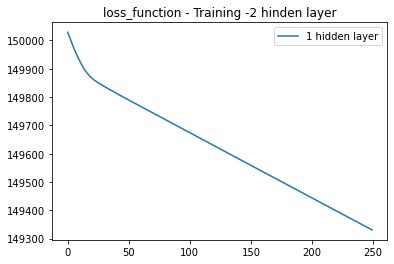

In [46]:
# Plot the loss function of the training results for the model
import matplotlib.pyplot as plt
plt.plot(model_1.history["loss"])
#plt.plot(model_2.history["loss"])
plt.title("loss_function - Training -2 hinden layer")
plt.legend(["1 hidden layer", "2 hidden layers"])
plt.show()

In [47]:
# # Reshape the features for the model
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [48]:
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

# Initial model setup
number_units = 8
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [49]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [50]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 8)             320       
                                                                 
 dropout (Dropout)           (None, 15, 8)             0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 8)             544       
                                                                 
 dropout_1 (Dropout)         (None, 15, 8)             0         
                                                                 
 lstm_2 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [51]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=250, shuffle=False, batch_size=3, verbose=1)

Epoch 1/250
25/25 [==============================] - 6s 11ms/step - loss: 1.0304
Epoch 2/250
25/25 [==============================] - 0s 12ms/step - loss: 1.0009
Epoch 3/250
25/25 [==============================] - 0s 12ms/step - loss: 0.9877
Epoch 4/250
25/25 [==============================] - 0s 12ms/step - loss: 0.9740
Epoch 5/250
25/25 [==============================] - 0s 12ms/step - loss: 0.9763
Epoch 6/250
25/25 [==============================] - 0s 12ms/step - loss: 0.9658
Epoch 7/250
25/25 [==============================] - 0s 12ms/step - loss: 0.9701
Epoch 8/250
25/25 [==============================] - 0s 12ms/step - loss: 0.9716
Epoch 9/250
25/25 [==============================] - 0s 14ms/step - loss: 0.9424
Epoch 10/250
25/25 [==============================] - 0s 11ms/step - loss: 0.9532
Epoch 11/250
25/25 [==============================] - 0s 11ms/step - loss: 0.9358
Epoch 12/250
25/25 [==============================] - 0s 12ms/step - loss: 0.9111
Epoch 13/250
25/25 [=====

In [52]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

3.7669360637664795

In [53]:
# Make some predictions
predicted = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [54]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [55]:
# Create a DataFrame of Real and Predicted values
assets = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = combined_asset_data.index[-len(real_prices): ]) 
assets.head()

,Real,Predicted
Date,,
2021-10-25,459.250000,350.609436
2021-11-01,468.529999,370.945587
2021-11-08,467.269989,364.746979
2021-11-15,468.890015,341.407013
2021-11-22,458.970001,418.216461


<AxesSubplot:title={'center':'Actual Vs. Predicted SPY Prices'}, xlabel='Date'>

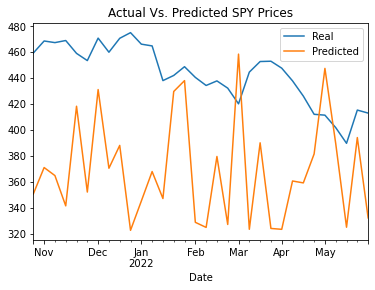

In [56]:
# Plot the real vs predicted values as a line chart
assets.plot(title="Actual Vs. Predicted SPY Prices")

# Predicting Market direction of SP500 with neural networks using the compiled sentiment scores

This code train a neural network model to predict whether a market environment for asset will be positive or negative 

The dataset contains 2 years of data on a weekly basis or 105 records with sentiment scores to be used 


In [57]:
# Define features data
X = all_sentiment_df.copy()

# Define target data
y = combined_asset_data['SPY UP(2)'].values
y = y.reshape(-1, 1)
y_crude = combined_asset_data['CRUDE UP(2)'].values
y_crude = y_crude.reshape(-1, 1)
y_gold = combined_asset_data['GOLD UP(2)'].values
y_gold = y_gold.reshape(-1, 1)
y_btc = combined_asset_data['BTC UP(2)'].values
y_btc = y_btc.reshape(-1, 1)
y_eth = combined_asset_data['ETH UP(2)'].values
y_eth = y_eth.reshape(-1, 1)

In [58]:
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

#SPY Definition
y_train = y[: split]
y_test = y[split:]
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)



# Create training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [59]:
# Create the scaler instance
# Most likely not needed as this is already a binary set defined above
X_scaler = StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the features data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [60]:
# Define the model
number_inputs = 15
number_hidden_nodes = 37

nn = Sequential()
nn.add(Dense(units=number_hidden_nodes, input_dim=number_inputs, activation="relu"))
nn.add(Dense(1, activation="sigmoid"))

# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [61]:
# Fit the model
model = nn.fit(X_train_scaled, y_train, epochs=250, verbose=0)

In [62]:
# saving model
nn_json = nn.to_json()

file_path = Path("./model.json")
with open(file_path, "w") as json_file:
    json_file.write(nn_json)

# Save weights
file_path = "./model.h5"
nn.save_weights("../model.h5")

<AxesSubplot:>

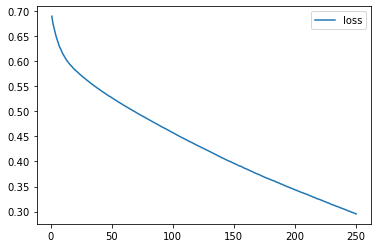

In [63]:
# Create a dataframe with the history dictionary
df_plot = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))

# Plot the loss
df_plot.plot(y="loss")

<AxesSubplot:>

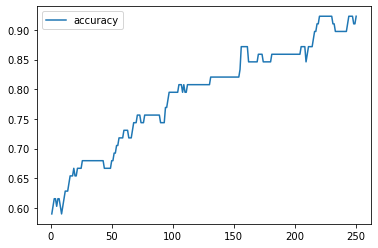

In [64]:
# Plot the accuracy
df_plot.plot(y="accuracy")

In [65]:
# Evaluate the model fit with linear dummy data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1/1 - 0s - loss: 0.8209 - accuracy: 0.6667 - 93ms/epoch - 93ms/step
Loss: 0.8209172487258911, Accuracy: 0.6666666865348816
